## Log-playback (expert) trajectory extraction and usage

This notebook demonstrates how to extract expert actions using different dynamics models and step through scene with those actions. 

Details on the dynamics models are found in [the docs](https://github.com/Emerge-Lab/gpudrive/tree/main/pygpudrive/env).

See also the [`LogTrajectory`](https://github.com/Emerge-Lab/gpudrive/blob/main/pygpudrive/datatypes/trajectory.py) datatype and [usage](https://github.com/Emerge-Lab/gpudrive/blob/c2ebb838a6b684c0f579c149bcb74f9cf31dc3ba/pygpudrive/env/env_torch.py#L436).

In [1]:
import os
from pathlib import Path
import mediapy

# Set working directory to the base directory 'gpudrive'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)

from pygpudrive.env.config import EnvConfig, SceneConfig
from pygpudrive.env.env_torch import GPUDriveTorchEnv
from pygpudrive.visualize.utils import img_from_fig

### Configurations

In [2]:
DYNAMICS_MODEL = "delta_local" # "delta_local" / "state" / "classic"
DATA_PATH = "data/processed/examples" # Your data path
MAX_NUM_OBJECTS = 32
NUM_ENVS = 4

# Configs
scene_config = SceneConfig(path=DATA_PATH, num_scenes=NUM_ENVS)
env_config = EnvConfig(dynamics_model=DYNAMICS_MODEL)

### Make environment

In [3]:
env = GPUDriveTorchEnv(
    config=env_config,
    scene_config=scene_config,
    max_cont_agents=MAX_NUM_OBJECTS,
    device="cpu",
    action_type="continuous" # "continuous" or "discrete"
)


--- Ratio unique scenes / number of worlds = 3 / 4 ---



### Get log-playback (expert) actions

- Different dynamics models have different action spaces. For details, [see the docs.](https://github.com/Emerge-Lab/gpudrive/tree/main/pygpudrive/env)

In [4]:
obs = env.reset()

In [5]:
# Extract full expert trajectory
expert_actions, _, _, _ = env.get_expert_actions()

expert_actions.shape # Shape: (num_envs, num_steps, num_agents, num_actions)

torch.Size([4, 32, 91, 3])

### Step through an episode

In [30]:
# Reset environment
obs = env.reset()
done_envs = []

frames = {f"env_{i}": [] for i in range(NUM_ENVS)}

# Step through the scene
for t in range(90):

    env.step_dynamics(expert_actions[:, :, t, :])
    
    dones = env.get_dones()
    
    # Render the scenes
    env_indices = [i for i in range(NUM_ENVS) if i not in done_envs]
    figs = env.vis.plot_simulator_state(
        env_indices=env_indices,
        time_steps=[t]*NUM_ENVS,
        figsize=(6, 6),
        zoom_radius=100,
        #center_agent_indices=[0]*NUM_ENVS,
    )
    for i, env_id in enumerate(env_indices):
        frames[f"env_{env_id}"].append(img_from_fig(figs[i])) 
    
    # Check if done
    for env_id in range(NUM_ENVS):
        if dones[env_id].all():
            done_envs.append(env_id)

## Show videos

env_0,env_1
env_2,env_3

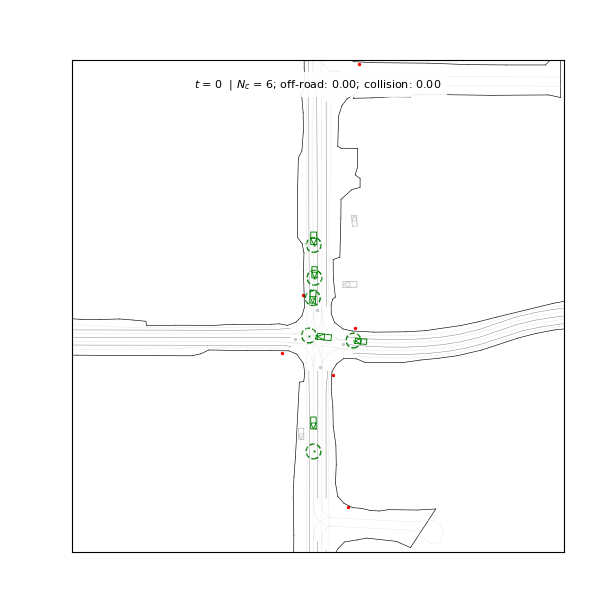
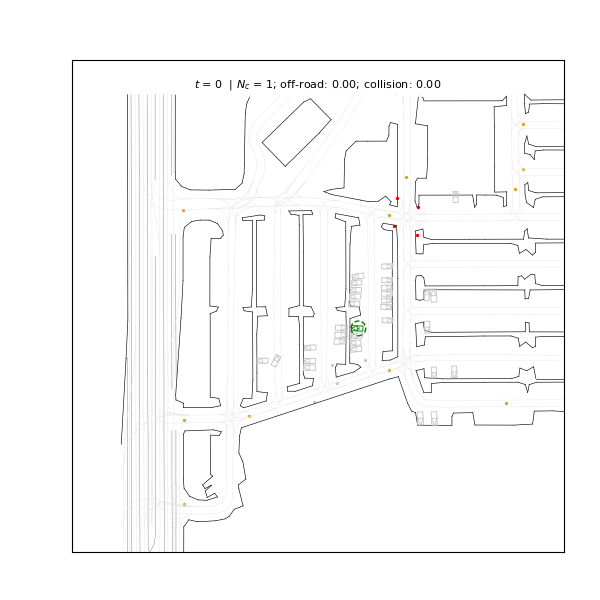
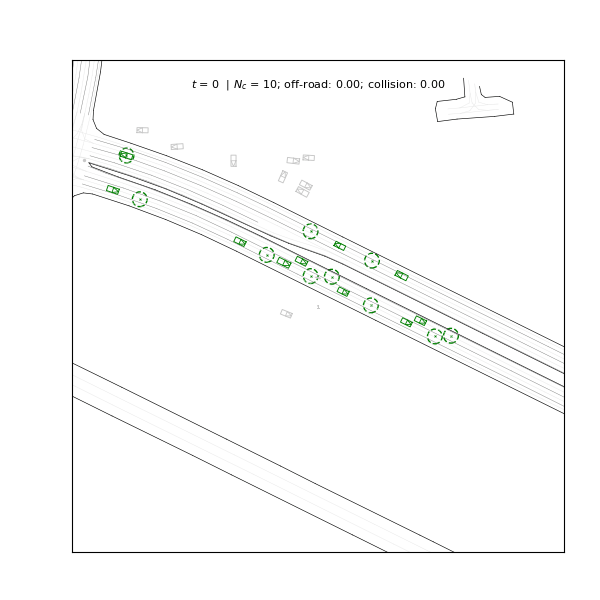
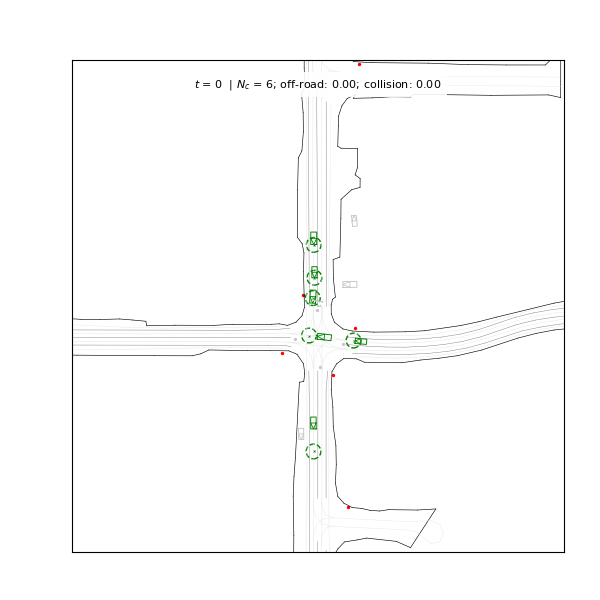

In [31]:
mediapy.show_videos(frames, fps=5, columns=2, codec='gif')